In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
%matplotlib inline

In [45]:
wiki=pd.read_csv('people_wiki.csv')

In [3]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [4]:
wiki.shape

(59071, 3)

In [5]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']  
    return csr_matrix( (data, indices, indptr), shape)

In [25]:
%time
word_count = load_sparse_csr('people_wiki_word_count.npz')
word_count

Wall time: 0 ns


<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [26]:
%%time
index_to_word=pd.read_json('people_wiki_map_index_to_word.json',typ='series')
index_reverse=pd.Series(index_to_word.index.values,index=index_to_word)
index_reverse.head()
index_reverse[116290]

Wall time: 971 ms


In [27]:
%%time
def each_row_index(words,index_r,row_num):    
    dic={}
    non_z=words[row_num].nonzero()[1]
    for j in range(len(non_z)):
        key=index_r[non_z[j]]
        values=words[row_num,non_z[j]]
        dic[key]=values
    return dic
word_list=[each_row_index(word_count,index_reverse,x) for x in range(len(wiki))]

Wall time: 7min 55s


In [28]:
%%time
def count_words(X, voc):
    """
    X: the return matrix of CountVectorizer.transform
    voc : vect.vocabulary_
    """
    rvoc = dict((v, k) for k, v in voc.iteritems())

    def count(row_id):
        dic = dict()
        for ind in X[row_id, :].indices:
            dic[rvoc[ind]] = X[row_id, ind]
        return dic
    word_count = list(map(count, range(0, X.shape[0])))
    return word_count
word_counts = count_words(word_count,index_to_word)

Wall time: 5min


In [37]:
from functools import partial

In [40]:
%%time
def each_row_index(words,index_r,row_num):    
    dic={}
    non_z=words[row_num].nonzero()[1]
    for j in range(len(non_z)):
        key=index_r[non_z[j]]
        values=words[row_num,non_z[j]]
        dic[key]=values
    return dic
word_list_2=list(map(partial(each_row_index,word_count,index_reverse),range(len(wiki))))

Wall time: 7min 43s


In [69]:
print(word_list_2==word_counts)
print(word_list==word_list_2)

True
True


In [51]:
%%time
translator=str.maketrans({k:'' for k in string.punctuation})
def trans(text):
    return text.translate(translator)
wiki['clean_text']=wiki['text'].apply(trans)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
word_count_matrix = vectorizer.fit_transform(wiki['clean_text'])

Wall time: 16.4 s


In [57]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(metric='euclidean',algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [95]:
wiki['word_count']=word_counts
wiki[wiki['name']=='Barack Obama']['word_count']

35817    {'husen': 1, '2012obama': 1, 'laureateduring':...
Name: word_count, dtype: object

In [77]:
word_count[0].indices

array([  5877,  92219, 227191, 446948, 468870, 477285, 492466, 509506,
       514262, 523996, 528953, 529843, 533540, 535034, 535475, 538022,
       538168, 540827, 541501, 541760, 542488, 542854, 542859, 542919,
       543517, 543802, 544119, 544367, 544602, 544982, 545219, 545515,
       545540, 545588, 545715, 545920, 546322, 546354, 546370, 546421,
       546503, 546518, 546570, 546634, 546639, 546696, 546703, 546719,
       546752, 546775, 546778, 546874, 546949, 547087, 547101, 547194,
       547210, 547260, 547261, 547359, 547478, 547492, 547498, 547536,
       547541, 547550, 547579, 547580, 547628, 547630, 547651, 547662,
       547667, 547674, 547687, 547689, 547705, 547708, 547731, 547745,
       547751, 547759, 547771, 547778, 547780, 547781, 547798, 547808,
       547809, 547825, 547837, 547839, 547843, 547844, 547849, 547856,
       547859, 547860, 547867, 547869, 547874, 547879, 547882, 547887,
       547889, 547899, 547901, 547904, 547910, 547913, 547914, 547916,
      

In [78]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st

In [117]:
neighbors=pd.DataFrame({'id':indices[0].tolist(), 'distance':distances[0].tolist()})

In [118]:
neighbors.head(2)

,id,distance
0,35817,0.000000
1,24478,33.075671


In [119]:
neighbors.set_index('id',inplace=True)

In [122]:
neighbors

,distance
id,
35817,0.000000
24478,33.075671
28447,34.394767
35357,36.152455
14754,36.166283
13229,36.331804
31423,36.400549
22745,36.496575
36364,36.633318


In [134]:
neighbors.join(wiki)[['name']+['distance']]

,name,distance
id,,
35817,Barack Obama,0.000000
24478,Joe Biden,33.075671
28447,George W. Bush,34.394767
35357,Lawrence Summers,36.152455
14754,Mitt Romney,36.166283
13229,Francisco Barrio,36.331804
31423,Walter Mondale,36.400549
22745,Wynn Normington Hugh-Jones,36.496575
36364,Don Bonker,36.633318


In [226]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    words=list(row['word_count'].tolist()[0].keys())
    counts=list(row['word_count'].tolist()[0].values())
    word_count_table = pd.DataFrame({'word':words,'count':counts})
    return word_count_table.sort_values('count', ascending=False)

In [275]:
obama_words = top_words('Barack Obama')
barrio_words = top_words('Francisco Barrio')
bush_words=top_words('George W. Bush')

In [234]:
obama_words.head()

,word,count
272,the,40
270,in,30
271,and,21
269,of,18
266,to,14


In [235]:
barrio_words.head()

,word,count
224,the,36
221,of,24
223,and,18
222,in,17
212,he,10


In [240]:
combined=obama_words.set_index('word').join(barrio_words.set_index('word'),lsuffix='_obama',rsuffix='_barrio')
combined.head()

,count_obama,count_barrio
word,,
the,40,36.0
in,30,17.0
and,21,18.0
of,18,24.0
to,14,9.0


In [411]:
common_words=obama_words['word'][:5].tolist()

In [249]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = list(word_count_vector.keys())  # YOUR CODE HERE
    return all([z in unique_words for z in common_words])
    # return True if common_words is a subset of unique_words
    # return False otherwise

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

In [549]:
wiki.head()

,URI,name,text,clean_text,word_count,has_top_words,tf-idf,tf_has_top,length
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'...",False,251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede...",False,223
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True,"{'germanyover': 10.986495389225194, 'bluesgosp...",False,226
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True,"{'fantasticrottensteiner': 10.986495389225194,...",False,377
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1...",False,201


In [552]:
np.sum(wiki['has_top_words'])

56066

In [258]:
print ('Output from your function:', has_top_words(wiki.iloc[32]['word_count']))
print ('Correct output: True')
print ('Output from your function:', has_top_words(wiki.iloc[33]['word_count']))
print ('Correct output: False')

Output from your function: True
Correct output: True
Output from your function: False
Correct output: False


In [271]:
obama_count=word_count[wiki[wiki['name']=='Barack Obama'].index]
biden_count=word_count[wiki[wiki['name']=='Joe Biden'].index]
bush_count=word_count[wiki[wiki['name']=='George W. Bush'].index]

In [272]:
from sklearn.metrics.pairwise import euclidean_distances

In [274]:
print(euclidean_distances(obama_count,biden_count))
print(euclidean_distances(obama_count,bush_count))
print(euclidean_distances(biden_count,bush_count))

[[33.07567082]]
[[34.39476704]]
[[32.75667871]]


In [283]:
obama_bush=obama_words.set_index('word').join(bush_words.set_index('word'),how='inner',lsuffix='_obama',rsuffix='_bush')
obama_bush_union=obama_words.set_index('word').join(bush_words.set_index('word'),how='outer',lsuffix='_obama',rsuffix='_bush')
print(obama_bush_union[:10])
obama_bush[:10]

      count_obama  count_bush
word                         
11            NaN         2.0
13th          1.0         NaN
1946          NaN         1.0
1961          1.0         NaN
1968          NaN         1.0
1975          NaN         1.0
1977          NaN         1.0
1992          1.0         NaN
1994          NaN         1.0
1995          NaN         1.0


,count_obama,count_bush
word,,
the,40,39
in,30,22
and,21,14
of,18,14
to,14,11
his,11,6
act,8,3
he,7,8
a,7,6


join(how='inner/outer') means intersection/union

In [292]:
tf_idf=load_sparse_csr('people_wiki_tf_idf.npz')

In [296]:
%%time
def tf_idf_vec(word,map_index,rowid):
    dic={}
    for i in tf_idf[rowid].indices:
        dic[map_index[i]]=tf_idf[rowid,i]
    return dic
tf_idf_lists=list(map(partial(tf_idf_vec,tf_idf,index_reverse),range(len(wiki))))

Wall time: 9min 16s


In [294]:
tf_idf[0].indices

array([  5877,  92219, 227191, 446948, 468870, 477285, 492466, 509506,
       514262, 523996, 528953, 529843, 533540, 535034, 535475, 538022,
       538168, 540827, 541501, 541760, 542488, 542854, 542859, 542919,
       543517, 543802, 544119, 544367, 544602, 544982, 545219, 545515,
       545540, 545588, 545715, 545920, 546322, 546354, 546370, 546421,
       546503, 546518, 546570, 546634, 546639, 546696, 546703, 546719,
       546752, 546775, 546778, 546874, 546949, 547087, 547101, 547194,
       547210, 547260, 547261, 547359, 547478, 547492, 547498, 547536,
       547541, 547550, 547579, 547580, 547628, 547630, 547651, 547662,
       547667, 547674, 547687, 547689, 547705, 547708, 547731, 547745,
       547751, 547759, 547771, 547778, 547780, 547781, 547798, 547808,
       547809, 547825, 547837, 547839, 547843, 547844, 547849, 547856,
       547859, 547860, 547867, 547869, 547874, 547879, 547882, 547887,
       547889, 547899, 547901, 547904, 547910, 547913, 547914, 547916,
      

In [297]:
wiki['tf-idf']=tf_idf_lists

In [298]:
wiki.head()

,URI,name,text,clean_text,word_count,has_top_words,tf-idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True,"{'germanyover': 10.986495389225194, 'bluesgosp..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True,"{'fantasticrottensteiner': 10.986495389225194,..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1..."


In [299]:
model_tfidf=NearestNeighbors(metric='euclidean',algorithm='brute')

In [300]:
model_tfidf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [302]:
distances, indices = model_tfidf.kneighbors(tf_idf[35817], n_neighbors=10)

In [321]:
print(wiki.loc[indices[0]]['name'].values.tolist())
print(wiki.loc[indices[0]]['name'].index.tolist())

['Barack Obama', 'Phil Schiliro', 'Jeff Sessions', 'Jesse Lee (politician)', 'Samantha Power', 'Bob Menendez', 'Eric Stern (politician)', 'James A. Guest', 'Roland Grossenbacher', 'Tulsi Gabbard']
[35817, 7914, 46811, 44681, 38376, 6507, 38714, 44825, 44368, 33417]


In [322]:
tfidf_neighbors=pd.DataFrame({'id':wiki.loc[indices[0]]['name'].index.tolist(),'distance':distances[0],'name':wiki.loc[indices[0]]['name'].values.tolist()})

In [324]:
tfidf_neighbors.set_index('id')

,distance,name
id,,
35817,0.000000,Barack Obama
7914,106.861014,Phil Schiliro
46811,108.871674,Jeff Sessions
44681,109.045698,Jesse Lee (politician)
38376,109.108106,Samantha Power
6507,109.781867,Bob Menendez
38714,109.957788,Eric Stern (politician)
44825,110.413889,James A. Guest
44368,110.470609,Roland Grossenbacher


In [393]:
def top_tfidf(name):
    row=wiki[wiki['name']==name]['tf-idf']
    table=pd.DataFrame({'word':list(row.values[0].keys()),'weight':list(row.values[0].values())}).sort_values('weight',ascending=False)
    return table

In [398]:
tf_obama=top_tfidf('Barack Obama')

In [399]:
tf_schiliro=top_tfidf('Phil Schiliro')

In [404]:
tf_combined=tf_obama.set_index('word').join(tf_schiliro.set_index('word'),how='inner',lsuffix='_obama_',rsuffix='_schiliro')

In [405]:
tf_combined.head(10)

,weight_obama_,weight_schiliro
word,,
obama,43.295653,9.621256
law,14.722936,7.361468
democratic,12.410689,6.205344
senate,10.164288,3.388096
presidential,7.386955,3.693478
president,7.226869,9.033587
policy,6.095386,3.047693
states,5.473201,1.824400
office,5.248173,2.624086


In [561]:
common_words_tf=tf_combined[:5].index.values.tolist()
wiki.head()

,URI,name,text,clean_text,word_count,has_top_words,tf-idf,tf_has_top,length
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'...",False,251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede...",False,223
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True,"{'germanyover': 10.986495389225194, 'bluesgosp...",False,226
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True,"{'fantasticrottensteiner': 10.986495389225194,...",False,377
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1...",False,201


In [562]:
def has_top_tf(word_vec):
    unique_words=list(word_vec.keys())
    return all([a in unique_words for b in common_words_tf])

In [563]:
wiki['tf_has_top']=wiki['tf-idf'].apply(has_top_tf)

In [564]:
def compute_length(row):
    return len(row.split(' '))
wiki['length'] = wiki['text'].apply(compute_length)

In [565]:
wiki.head(2)

,URI,name,text,clean_text,word_count,has_top_words,tf-idf,tf_has_top,length
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'...",False,251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede...",False,223


In [566]:
tf_distances, tf_indices = model_tfidf.kneighbors(tf_idf[35817], n_neighbors=100)

In [567]:
tfidf_neighbors=pd.DataFrame({'name':wiki.iloc[tf_indices[0]]['name'].values,'distance':tf_distances[0],'length':wiki.iloc[tf_indices[0]]['length'].values})

In [568]:
np.sum(wiki['tf_has_top'])

0

In [458]:
tfidf_neighbors.head(10)

,name,distance,length
0,Barack Obama,0.000000,540
1,Phil Schiliro,106.861014,208
2,Jeff Sessions,108.871674,230
3,Jesse Lee (politician),109.045698,216
4,Samantha Power,109.108106,310
5,Bob Menendez,109.781867,220
6,Eric Stern (politician),109.957788,255
7,James A. Guest,110.413889,215
8,Roland Grossenbacher,110.470609,201
9,Tulsi Gabbard,110.696998,228


C:\Users\shuoyan001\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


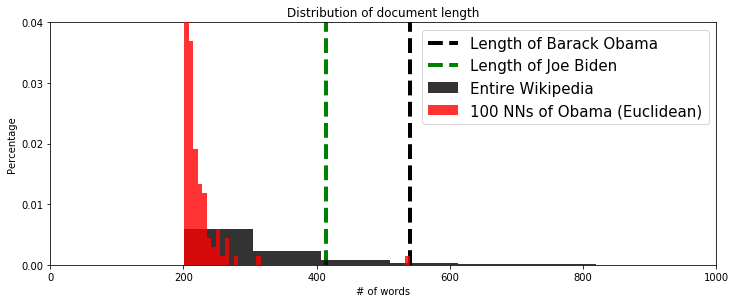

In [465]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(tfidf_neighbors['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values, color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values, color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [463]:
wiki['length'][wiki['name'] == 'Barack Obama'].values

array([540], dtype=int64)

In [467]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
cos_distances, cos_indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

In [468]:
cos_neighbors=pd.DataFrame({'name':wiki.iloc[cos_indices[0]]['name'].values,'distance':cos_distances[0],'length':wiki.iloc[cos_indices[0]]['length'].values})

In [470]:
cos_neighbors.head()

,name,distance,length
0,Barack Obama,0.000000,540
1,Joe Biden,0.703139,414
2,Samantha Power,0.742982,310
3,Hillary Rodham Clinton,0.758358,580
4,Eric Stern (politician),0.770561,255


C:\Users\shuoyan001\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 756x324 with 0 Axes>

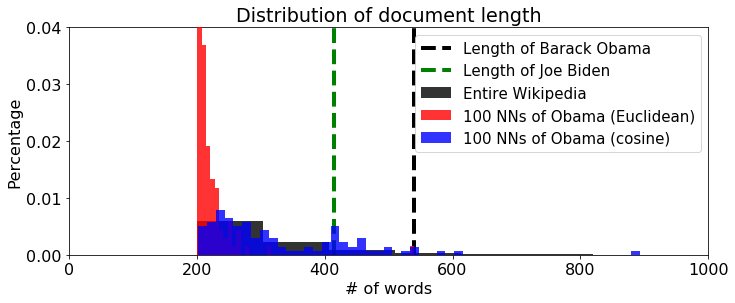

In [472]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(tfidf_neighbors['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(cos_neighbors['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values, color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values, color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [473]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

In [541]:
tweet_index=[]
for i in tweet.keys():
    tweet_index.append(index_reverse[index_reverse.values==i].index[0])

In [547]:
tweet_sparse=csr_matrix((list(tweet.values()),([0]*len(tweet_index),tweet_index)),shape=(1,tf_idf.shape[1]))
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = tf_idf[35817]
print (cosine_distances(obama_tf_idf, tweet_sparse))


[[0.70591838]]


In [548]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)
print (distances)

[[0.         0.70313868 0.7429819  0.7583584  0.77056123 0.7846775
  0.78803907 0.79092642 0.7983226  0.79946636]]
